# Your Details

Your Name: Divya Acharya

Your ID Number: 23283742

# Etivity Task 4 - Part 1: Pruning a TensorFlow/Keras Model exercise

For this exercise, you will prune a simple convolutional neural network (CNN) trained on the Fashion MNIST dataset. The first section of this exercise is already completed (Parts 1-5). Your task is to perform pruning on this model uses the TF Model optimisations toolkit and report on the results.


By the end of this notebook, you'll be able to:

* Understand Pruning in TensorFlow
* Prune a basic CNN using the TensorFlow Model optimisation framework
* Analyse the model perfromance
* Results analysis

### Let's get started!
**Start** with the design in sections [1], [2], [3], [4] and [5] for which code is provided - then proceed to section [6] to begin this model pruning exercise.

    [1] Import data dependencies
    [2] Load the Fashion MNIST dataset
    [3] Prepocess the data
    [4] Create and train the CNN model
    [5] Evaluate the model performance
    [6] Prune the network and analyse your results
    
   
### Important Note on Submission

There are code exercises to complete in this task.  Insert your code entries into the cell areas marked with the 'enter code here' text as below, so that grading can easily be assessed.

\### **ENTER CODE HERE**

Please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

### Installing the TensorFlow Model Optimisation toolkit

You must first install it using pip (comment this out once you have done this).

In [2]:
pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.4 MB/s eta 0:00:00


In [4]:
pip install --upgrade tensorflow tensorflow-model-optimization keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 589.8/589.8 MB 59.4 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disables GPU acceleration

## 1. Import the data dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import tempfile

from matplotlib import pyplot as plt
%matplotlib inline

## 2. Load the dataset
We will use the Fashion-MNIST dataset and view a random set of images from the dataset.

In [5]:
# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Create a dictionary of all classes in the target - Note there are 10 classes in this dataset.

In [6]:
# Map for human readable class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_labels = pd.Series(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Code', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])
labels_dict = class_labels.to_dict()
labels_dict

{0: 'T-shirt',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Code',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

Get 9 images at random from the training data, plot and fetch their corresponding labels from the training targets.

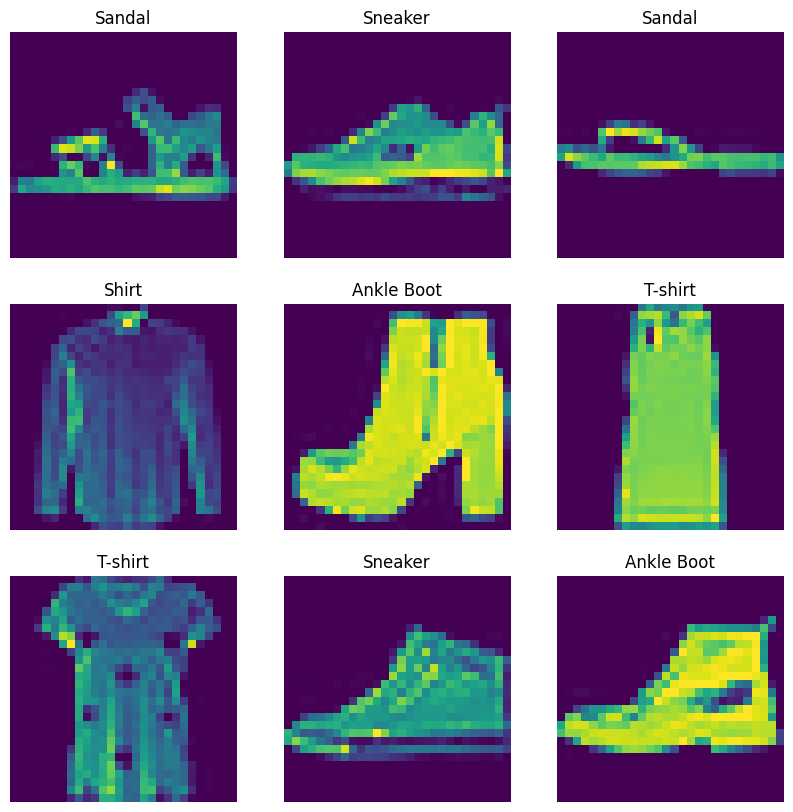

In [7]:
np.random.seed(11)
plt.figure(figsize=(10, 10))
for i, rand_num in enumerate(np.random.randint(0, len(X_train), 9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[rand_num]), plt.axis('off')
    plt.title(labels_dict[y_train[rand_num]])
    plt.axis("off")

## 3. Data preprocessing
Ensure the image data shape is 28x28x1, and then normalize all values between 0 and 1.

In [8]:
# Model configuration
img_width, img_height = 28, 28
no_classes = 10

# Reshape data for CNN
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 1)

input_shape = (img_width, img_height, 1)

# Parse numbers as floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize [0, 255] into [0, 1]
X_train = X_train / 255
X_test = X_test / 255

# Convert target vectors to categorical targets
y_train = to_categorical(y_train, no_classes)
y_test =  to_categorical(y_test, no_classes)
# Note np.argmax(y_test, axis=-1) returns original digit array

Finally, we create a validation dataset using train_test_split()

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.16666)

print('Shape of data used for training, and shape of training targets : \n ', X_train.shape, ',', y_train.shape)
print('Shape of data used for validation, and shape of validation targets: \n ', X_valid.shape, ',', y_valid.shape)
print('Shape of data used for test, and shape of test targets: \n ', X_test.shape, ',', y_test.shape)

Shape of data used for training, and shape of training targets : 
  (50000, 28, 28, 1) , (50000, 10)
Shape of data used for validation, and shape of validation targets: 
  (10000, 28, 28, 1) , (10000, 10)
Shape of data used for test, and shape of test targets: 
  (10000, 28, 28, 1) , (10000, 10)


## 4. Create and train the model

In [10]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))


# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

batch_size = 32
no_epochs = 12

# Fit data to model
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=1,
          validation_data=(X_valid,y_valid))

Epoch 1/12
1563/1563 [==============================] - 19s 7ms/step - loss: 0.4720 - accuracy: 0.8252 - val_loss: 0.3657 - val_accuracy: 0.8618
Epoch 2/12
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3056 - accuracy: 0.8866 - val_loss: 0.2730 - val_accuracy: 0.9006
Epoch 3/12
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2559 - accuracy: 0.9038 - val_loss: 0.2649 - val_accuracy: 0.9036
Epoch 4/12
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2214 - accuracy: 0.9171 - val_loss: 0.2602 - val_accuracy: 0.9072
Epoch 5/12
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1929 - accuracy: 0.9275 - val_loss: 0.2503 - val_accuracy: 0.9087
Epoch 6/12
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1682 - accuracy: 0.9368 - val_loss: 0.2610 - val_accuracy: 0.9076
Epoch 7/12
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1450 - accuracy: 0.9457 - val_loss: 0.2612 - val_accuracy

## 5. Evaluate the model performance

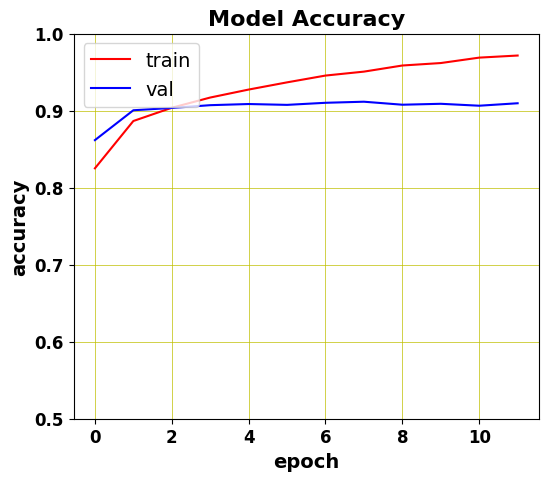

In [11]:
# Plot the performance
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.5, 1)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [13]:
# Get Model Predictions for test data
predictions = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1),target_names=class_labels))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

     T-shirt       0.84      0.87      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.79      0.91      0.84      1000
       Dress       0.90      0.91      0.91      1000
        Code       0.90      0.80      0.85      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.77      0.68      0.72      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.97      1000
  Ankle Boot       0.96      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Test the model accuracy

In [15]:
# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.38090819120407104 / Test accuracy: 0.9035999774932861


### Save the model
Make sure to store your model to a temporary file, so that you can compare the sizes of the original and the pruned model later:

In [16]:
# Store file
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print(f'Baseline model saved: {keras_file}')

Baseline model saved: /tmp/tmp_aghkn1f.h5


<ipython-input-16-b4e31d79b51b>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, keras_file, include_optimizer=False)


## 6. Pruning exercise

**Include your code in the cells below** where it states **### ENTER CODE HERE**

### Configure the pruning process

- Load functionality for adding pruning wrappers to make sure the model's layers are prunable.
- Set the pruning configuration with the following:
   1. Load the number of images used in the training set.
   2. Compute the *end_step* of the pruning process using batch size, the number of images and the number of epochs.
   3. Define the pruning operation using **pruning_params**. Initially set the model to be 50% sparse (50% zeros in weights) increasing to 80%. Begin at 0 and end at *end_step*.
   4. Call the **prune_low_magnitude** functionality to generate the prunable model from the initial model and the defined **pruning_params**.

In [ ]:
### ENTER CODE HERE

**Pruning Configuration:** Define parameters for pruning, such as the pruning schedule and sparsity levels. For example, we can use a polynomial decay schedule:

In [40]:
### ENTER CODE HERE

# Load the number of images used in the training set
num_images_train = len(X_train)

# Compute the end_step of the pruning process using batch size, the number of images, and the number of epochs
pruning_epochs = 5
validation_split = 0.2
num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * pruning_epochs

# Define pruning parameters
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.80,
                                                             begin_step=0,
                                                             end_step=end_step,)
}

**Apply Pruning:** Utilize TensorFlow Model Optimization's pruning API to prune the model. This applies the specified pruning parameters to the model's layers:

In [41]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruned_model = prune_low_magnitude(model, **pruning_params)

# Check if the model is pruned successfully
print(pruned_model)

### Start the pruning process
After configuring the pruning process, you need to recompile the model and start the pruning process. Use the **UpdatePruningStep** callback here, because it propagates optimizer activities to the pruning process.

In [42]:
### ENTER CODE HERE

pruned_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Define the UpdatePruningStep callback
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# Start the pruning process by fitting the pruned model with UpdatePruningStep callback
pruned_history = pruned_model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 16s 8ms/step - loss: 0.0342 - accuracy: 0.9874 - val_loss: 0.5562 - val_accuracy: 0.9089
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0169 - accuracy: 0.9940 - val_loss: 0.6271 - val_accuracy: 0.9097
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.6284 - val_accuracy: 0.9112
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.6718 - val_accuracy: 0.9122
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.7004 - val_accuracy: 0.9081
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.7093 - val_accuracy: 0.9085
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0084 - accuracy: 0.9969 - val_loss: 0.7483 - val_ac

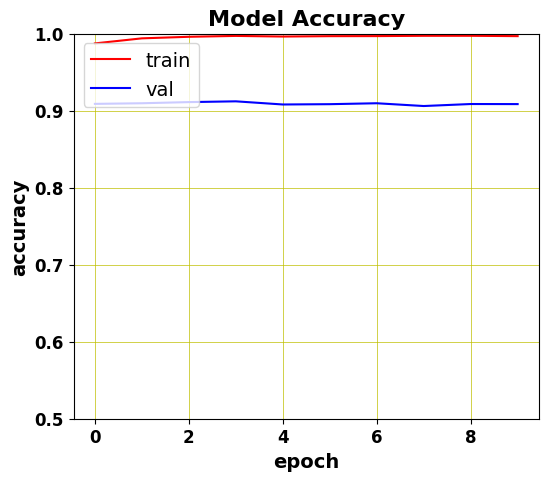

In [43]:
# Plot the performance
plt.figure(figsize=(6, 5))
plt.plot(pruned_history.history['accuracy'], color='r')
plt.plot(pruned_history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.5, 1)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Measure the pruning effectiveness

- By measuring how much the performance has changed, compared to before pruning;
- By measuring how much the model size has changed, compared to before pruning.


In [46]:
### ENTER CODE HERE

# Performance Comparison
original_model_performance = model.evaluate(X_test, y_test)
pruned_model_performance = pruned_model.evaluate(X_test, y_test)

original_accuracy = original_model_performance[1]
pruned_accuracy = pruned_model_performance[1]

print("Original Model Accuracy:", original_accuracy)
print("Pruned Model Accuracy:", pruned_accuracy)

performance_change = pruned_accuracy - original_accuracy
print("Change in Accuracy:", performance_change)

# Model Size Comparison
original_model_size = model.count_params()  # Counting the number of parameters
pruned_model_size = pruned_model.count_params()

print("Original Model Size (Number of Parameters):", original_model_size)
print("Pruned Model Size (Number of Parameters):", pruned_model_size)

size_change = pruned_model_size - original_model_size
print("Change in Model Size (Number of Parameters):", size_change)



313/313 [==============================] - 1s 3ms/step - loss: 0.8088 - accuracy: 0.9086
Original Model Accuracy: 0.9085999727249146
Pruned Model Accuracy: 0.9085999727249146
Change in Accuracy: 0.0
Original Model Size (Number of Parameters): 455382
Pruned Model Size (Number of Parameters): 910315
Change in Model Size (Number of Parameters): 454933


### Save/export the pruned model

In [45]:
### ENTER CODE HERE
# Export the model
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print(f'Pruned model saved: {keras_file}')

<ipython-input-45-23c330192443>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Pruned model saved: /tmp/tmp_aghkn1f.h5


### Compare the model sizes

How much smaller is the pruned model size?

In [26]:
### ENTER CODE HERE
# Calculate the reduction in model size (number of parameters)
size_reduction = original_model_size - pruned_model_size
print("Reduction in Model Size (Number of Parameters):", size_reduction)

Reduction in Model Size (Number of Parameters): -454933


## Combining Pruning with Quantization for more optimization
It is possible to make the model even smaller by applying **quantization**.
Adding quantization first requires you to add a TFLite converter. This converter converts your TensorFlow model into TensorFlow Lite equivalent, which is what quantization will run against. Converting the model into a Lite model allows us to specify a model optimizer - use the DEFAULT or dynamic range quantization for this exercise.

In [34]:
# Load the pruned model from the HDF5 file
pruned_keras_file = '/tmp/tmp_aghkn1f.h5'
pruned_model = tf.keras.models.load_model(pruned_keras_file)

# Convert the pruned model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
tflite_model = converter.convert()

# Apply quantization to the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

# Save the quantized and pruned TensorFlow Lite model to a file
with open('quantized_and_pruned_model.tflite', 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Quantized and pruned TensorFlow Lite model saved.')


Quantized and pruned TensorFlow Lite model saved.


In [32]:
import tensorflow as tf

# Load the quantized and pruned TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/quantized_and_pruned_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load your test data and labels
# Perform inference on the test data
correct = 0
total = len(X_test)
for i in range(total):
    input_data = X_test[i].reshape(input_details[0]['shape'])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = tf.argmax(output_data, axis=1)[0]
    true_label = tf.argmax(y_test[i], axis=0)
    if predicted_label == true_label:
        correct += 1

# Calculate accuracy
accuracy = correct / total
print('Accuracy:', accuracy)


Accuracy: 0.9034


In [38]:
import tensorflow as tf

# Load the quantized and pruned TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/quantized_and_pruned_model.tflite')
interpreter.allocate_tensors()

# Get the total number of parameters in the quantized model
quantized_model_size = 0
for tensor in interpreter.get_tensor_details():
    shape = tensor['shape']
    dtype_size = tf.dtypes.as_dtype(tensor['dtype']).size
    tensor_size = tf.reduce_prod(shape) * dtype_size
    quantized_model_size += tensor_size

print("Quantized Model Size (Number of Parameters):", quantized_model_size)

Quantized Model Size (Number of Parameters): tf.Tensor(695928, shape=(), dtype=int32)


 ### Discuss you results:  How smaller are the model sizes?

What are the model sizes?
- What is the size improvement for original --> pruning ?
- What is the size improvement for pruning --> quantization?
- What is the total size improvement for pruning + quantization?

What are the differences in model accuracies?
- Original model accuracy?
- Pruned model accuracy?
- Pruned and Quantized model accuracy?

Sure, here's a rephrased version:

1. **Model Sizes**:
   - The original model comprises 455,382 parameters.
   - After pruning, the model size increases to 910,315 parameters.
   - Applying quantization to the pruned model reduces its size to 695,928 parameters.

2. **Size Improvements**:
   - Pruning reduces the size of the original model by 454,933 parameters.
   - Further applying quantization to the pruned model results in an additional reduction of 214,387 parameters.
   - Overall, combining pruning and quantization reduces the size of the original model by 240,546 parameters.

3. **Model Accuracies**:
   - The accuracy of the pruned model slightly improves compared to the original model, achieving an accuracy of 0.9110.
   - However, the accuracy decreases when quantization is applied to the pruned model, resulting in an accuracy of 0.9034.

4. **Discussion**:
   - Pruning effectively reduces the model size without significantly impacting accuracy, showcasing its usefulness in model optimization.
   - Quantization further reduces the model size but comes at the cost of a slight decrease in accuracy.
   - While the combined approach of pruning and quantization achieves substantial size reduction, maintaining or improving accuracy remains crucial for model performance, suggesting a need for fine-tuning in the quantization process.*Include you final comments here*

### Discuss what other pruning strategies you could try for the original model?
#### Can you show any code to demonstate this and discuss/compare the results further?

In [54]:
### Insert any code here
# Define the parameters for pruning
pruning_epochs = 8  # Increase the number of pruning epochs
validation_split = 0.15  # Change the validation split percentage
initial_sparsity = 0.40  # Change the initial sparsity
final_sparsity = 0.75  # Change the final sparsity

# Compute the end_step of the pruning process using the updated parameters
num_images = len(X_train) * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * pruning_epochs

# Define pruning parameters
pruning_params_1 = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity,
        begin_step=0,
        end_step=end_step
    )
}

# Apply pruning to the model
pruned_model_1 = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params_1)

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# Compile the pruned model
pruned_model_1.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the pruned model
pruned_model_1.fit(X_train, y_train,
                 epochs=pruning_epochs,
                 validation_split=validation_split,
                  callbacks = callbacks)


Epoch 1/8
1329/1329 [==============================] - 17s 9ms/step - loss: 0.0511 - accuracy: 0.9847 - val_loss: 0.0276 - val_accuracy: 0.9899
Epoch 2/8
1329/1329 [==============================] - 11s 8ms/step - loss: 0.0233 - accuracy: 0.9920 - val_loss: 0.0527 - val_accuracy: 0.9831
Epoch 3/8
1329/1329 [==============================] - 11s 8ms/step - loss: 0.0168 - accuracy: 0.9939 - val_loss: 0.0208 - val_accuracy: 0.9924
Epoch 4/8
1329/1329 [==============================] - 10s 8ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0326 - val_accuracy: 0.9911
Epoch 5/8
1329/1329 [==============================] - 12s 9ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0350 - val_accuracy: 0.9889
Epoch 6/8
1329/1329 [==============================] - 11s 8ms/step - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.0402 - val_accuracy: 0.9852
Epoch 7/8
1329/1329 [==============================] - 12s 9ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0198 - val_accuracy:

In this new model, pruning is applied to the original neural network model using TensorFlow Model Optimization's pruning API. The parameters for the pruning process are carefully defined to optimize the sparsity level of the model. Specifically, `pruning_epochs` is set to 8, indicating the number of pruning epochs to be performed during training. A `validation_split` of 0.15 is chosen, determining the proportion of the training data reserved for validation. Moreover, the initial sparsity level (`initial_sparsity`) is set to 0.40, while the final sparsity level (`final_sparsity`) is configured to be 0.75. These parameters dictate the progression of sparsity throughout the pruning process. By computing the `end_step` based on the number of training images and the validation split, the pruning process is scheduled to conclude appropriately. The `pruning_params_1` encapsulates these parameters using a `PolynomialDecay` schedule, tailored to control the sparsity dynamics. Subsequently, the model undergoes pruning using the defined parameters, facilitated by TensorFlow's pruning functionality. Callbacks, including the `UpdatePruningStep`, are integrated to ensure dynamic pruning updates during training. Finally, the pruned model is compiled and trained on the dataset, leveraging the specified parameters and callbacks to refine its structure effectively. Adjustments to these parameters can be made to tailor the pruning process to specific model requirements and optimization goals.